# Testing the object insertion functions

In [4]:
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import cv2
import os
from tqdm import tqdm

## Guided anchoring

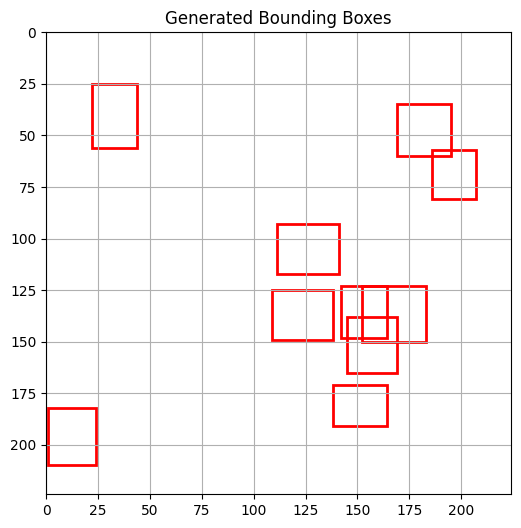

In [4]:
def generate_random_bboxes(num_boxes, max_size=224, min_box_size=20, max_box_size=32):
    """
    Generates a list of random bounding boxes within the given image size.

    Args:
        num_boxes (int): Number of bounding boxes to generate.
        max_size (int): The size of the image (e.g., 224 for a 224x224 image).
        min_box_size (int): Minimum width/height of a bounding box.
        max_box_size (int): Maximum width/height of a bounding box.

    Returns:
        List of bounding boxes: [[x_min, y_min, x_max, y_max], ...]
    """
    bboxes = []

    for _ in range(num_boxes):
        w = random.randint(min_box_size, max_box_size)
        h = random.randint(min_box_size, max_box_size)

        x_min = random.randint(0, max_size - w)
        y_min = random.randint(0, max_size - h)

        x_max = x_min + w
        y_max = y_min + h

        bboxes.append([x_min, y_min, x_max, y_max])

    return bboxes

test_bboxes = generate_random_bboxes(10)  # 10 random boxes within 224x224

def plot_bboxes(bboxes, img_size=224):
    fig, ax = plt.subplots(1, figsize=(6, 6))
    ax.set_xlim([0, img_size])
    ax.set_ylim([0, img_size])
    ax.set_title("Generated Bounding Boxes")
    ax.invert_yaxis()  # Optional: to match image coordinate system

    for box in bboxes:
        x_min, y_min, x_max, y_max = box
        rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                 linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.grid(True)
    plt.show()
plot_bboxes(test_bboxes)


In [8]:
def locate_anchor(dst_bbox):
    """
    Generates a new bounding box that is close to but does not overlap with the given bounding box.
    The new bounding box may have a different size.

    Args:
        src_bbox (list): [x_min, y_min, x_max, y_max] representing the original bounding box.
        min_distance (int): Minimum distance to move the new bounding box away.
        max_distance (int): Maximum distance to move the new bounding box away.
        size_variation (float): Maximum percentage by which the new box size can vary (e.g., 0.5 = ±50%).

    Returns:
        list: [x_min, y_min, x_max, y_max] for the new non-overlapping bounding box.
    """

    obj_size = (random.randint(1, 32), random.randint(1, 32))

    # Initialize minimum and maximum distance to move the new bounding box
    min_distance = 0.2 * obj_size[0]
    max_distance = 0.5 * obj_size[0]

    # Calculate scaling factors
    scale = 0.5

    # Extract destination bounding box information
    x_min, y_min, x_max, y_max = dst_bbox
    center_x = (x_min + x_max) / 2
    center_y = (y_min + y_max) / 2
    width = x_max - x_min
    height = y_max - y_min

    for i in range(100):
        # Compute diagonal distances (to ensure proper separation)
        orig_diag = np.sqrt(width ** 2 + height ** 2) / 2

        # Choose a random angle (0 to 360 degrees)
        angle = random.uniform(0, 2 * np.pi)

        # Ensure the distance is at least greater than the diagonal
        min_safe_distance = orig_diag + min_distance
        max_safe_distance = orig_diag + max_distance
        distance = random.uniform(min_safe_distance, max_safe_distance)

        # First scale the center to target space
        center_x_scaled = center_x * scale
        center_y_scaled = center_y * scale

        # Then apply distance shift in target space
        new_center_x = center_x + distance * np.cos(angle)
        new_center_y = center_y + distance * np.sin(angle)

        # Compute new bounding box coordinates
        new_x_min = int(new_center_x - obj_size[0] / 2)
        new_y_min = int(new_center_y - obj_size[1] / 2)
        new_x_max = int(new_center_x + obj_size[0] / 2)
        new_y_max = int(new_center_y + obj_size[1] / 2)

        new_bbox = [new_x_min, new_y_min, new_x_max, new_y_max]

        if min(new_bbox) > 20 and max(new_bbox) < (224 - 20):
            final_bbox = new_bbox
            return final_bbox

    return None

for box in test_bboxes:
    anchor = locate_anchor(box)
    print(anchor, box)

[125, 172, 138, 180] [138, 171, 164, 191]
[49, 36, 72, 58] [22, 25, 44, 56]
[171, 69, 181, 77] [186, 57, 207, 81]
[133, 132, 141, 158] [142, 123, 164, 148]
[129, 149, 156, 167] [152, 123, 183, 150]
[85, 123, 107, 139] [109, 125, 138, 149]
[21, 187, 49, 188] [1, 182, 24, 210]
[141, 47, 164, 51] [169, 35, 195, 60]
[100, 74, 117, 90] [111, 93, 141, 117]
[169, 157, 187, 174] [145, 138, 169, 165]


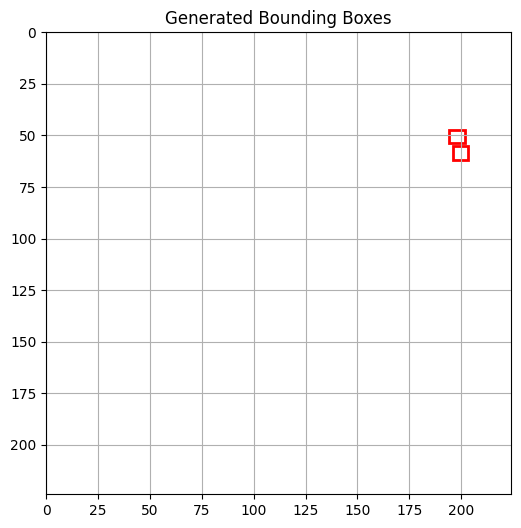

In [11]:
test_bboxes =[[194.25, 47.25, 201.6875, 53.8125], [196, 55, 203, 62]]
plot_bboxes(test_bboxes)

## Creating Masks

In [7]:
def create_mask(obj):
    gray_obj = cv2.cvtColor(obj, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to reduce the noise
    blur_obj = cv2.GaussianBlur(gray_obj, (3, 3), 0)

    # Auto threshold using Otsu's method
    _, binary = cv2.threshold(blur_obj, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Morphological operations to clean the mask
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    clean = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=1)
    clean = cv2.morphologyEx(clean, cv2.MORPH_CLOSE, kernel, iterations=1)

    return clean

  0%|          | 0/4054 [00:00<?, ?it/s]

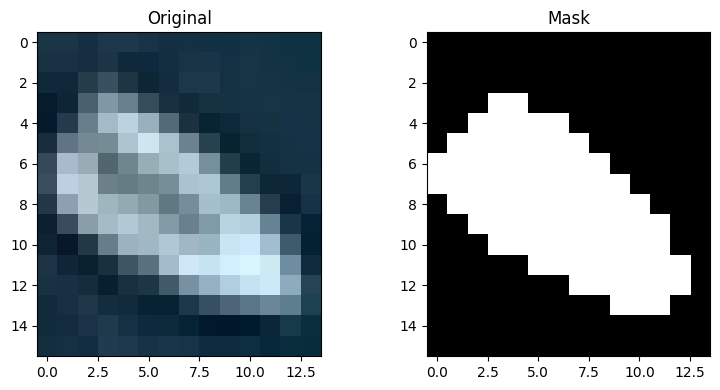

  0%|          | 1/4054 [00:00<16:49,  4.01it/s]

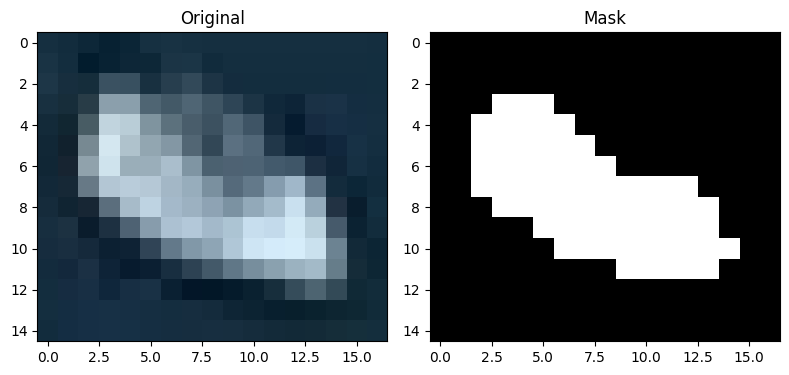

  0%|          | 2/4054 [00:00<15:44,  4.29it/s]

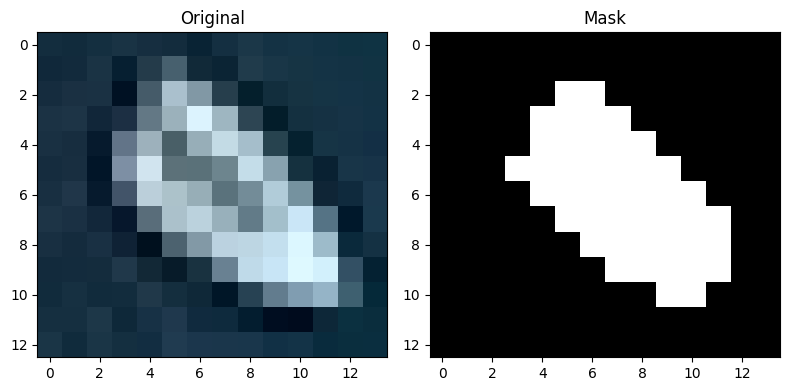

  0%|          | 3/4054 [00:00<15:19,  4.40it/s]

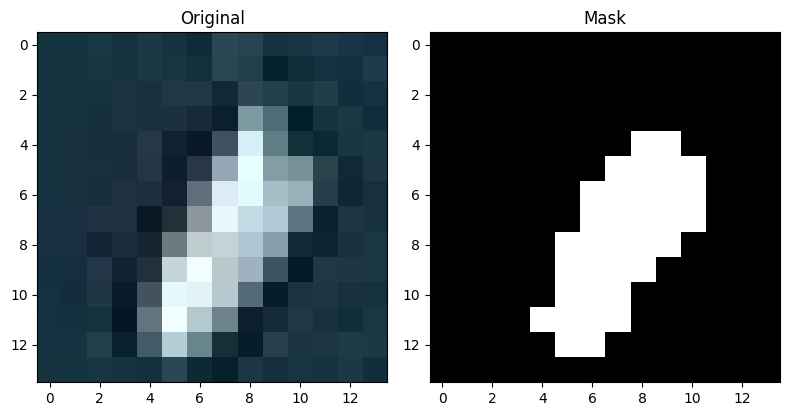

  0%|          | 4/4054 [00:00<14:56,  4.52it/s]

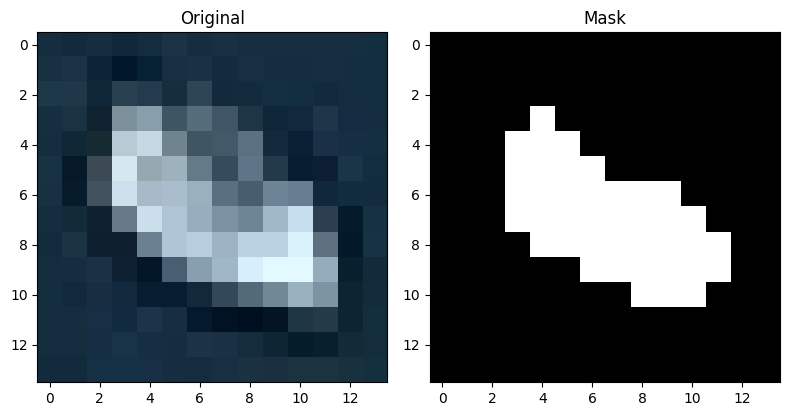

  0%|          | 5/4054 [00:01<15:03,  4.48it/s]


In [14]:
# Load image using OpenCV
path = "E:/Datasets/MasatiV2/MasatiV2Boats"
max_plots = 5
count = 0

for file in tqdm(os.listdir(path)):
    if count >= max_plots:
        break

    img_path = os.path.join(path, file)
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)

    obj = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = create_mask(obj)

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(obj)
    plt.title('Original')

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.title('Mask')

    plt.tight_layout()
    plt.show()

    count += 1